In [33]:
%reset -f
%matplotlib inline

import numpy as np
from scipy.special import legendre
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import nlopt

This code solves the 'time since infection' model described in our recent report [arxiv link when available].

$\frac{dS}{dt} = -R_0S\int_{-1}^{1}\beta(s)I(t,s)ds$

$\frac{\partial I}{\partial t} + \frac{\partial I}{\partial s} = 0$

$I(t,-1) = -\frac{dS}{dt}$

This code also considers the generalization to age-structured models and allows for an arbitrary number of sub-classes to the infected population with arbitrary time-dependent probabilities for entering/leaving those sub-classes

In [34]:
#######################################
###                                 ###
###   Transmission Characteristics  ###
###                                 ###
#######################################

T = 15       #What's the longest time (in days) for which a person can be infectious?
Td = 5       #What's the doubling time (in days) when in the linear growth regime?

#Make a linear interpolating function to describe how infectious a person is as a function of time since infection
#Note 1:  at present, we assume the -shape- of beta(s) is the same for all age groups
#Note 2:  beta(s) is an averaged value of transmission per unit normal contact (arbitrary units)
         #People who self-isolate or quarrantine are represented as reducing beta instead of reducing contacts
tsi = np.array([0,   3,    5,   10,   T])   #time since infection (days)
beta =np.array([0,   0.5,  1,   .5,   0])   #mean infectiousness (arbitrary units)
#for more detail on beta(s) and its interpretation, please see our report, section 2.2

#######################################
###                                 ###
###   Population Characteristics    ###
###                                 ###
#######################################

M = 2                #Number of age groups to model
Ni = 10**6*np.ones(M)  #Number of people in each age group
Np = sum(Ni)         #total population size

#Contact Matrix with arbitrary time dependence.  If using 'Hybrid' method, update tswap accordingly
def Cij_dim(t):
    return np.array([[4, 1],[1, 2]])


#######################################
###                                 ###
###    Infecteds Characteristics    ###
###           (optional)            ###
###                                 ###
#######################################

#Define sub-classes of infecteds - optional
subclasses = ['Recovered', 'Hospitalized', 'Deceased'] #e.g. Recovered, Hospitalized, Deceased
Nc = len(subclasses)

#Describe the dynamics of how people move in and out of subclasses.  See section 2.2 of report
if Nc > 0:
    #define the probability of eventually having membership in one 
    pR = 0.99*np.ones(M);  #probability of eventually recovering for each age class
    pH = 0.05*np.ones(M);  #probability of needing hospitalization for each age class
    pD = 1-pR;             #probability of death for each age class
    
    #prepare for a linear interpolating function evaluated at times:
    tsi_sc  =  np.array([0,   3.,    6.,    9.,   12,    T])  #For convenience, we say that you reach your final state at time T
                                                              #if this is not OK, adjust previous section accordingly
    
    #probability density function (arbitrary units) for transferring to each of the defined subclasses at tsi
    #once again, the 'shape' of these curves is assumed to be same for all age classes.
    phiR     = np.array([0,    0,    0.5,   3,     2,     0])  #rate of transferring to 'recovered' (arbitrary units)
    phiH_in  = np.array([0,    0,    1,     1,     0,     0])  #rate that people enter hospital     (arbitrary units)
    phiH_out = np.array([0,    0,    0,     1,     1,     0])  #rate that people enter hospital     (arbitrary units)
    phiD     = np.array([0,    0,    0,     1,     1,    .5])  #times at which a person dies        (arbitrary units)
    
    #combine hospital in/out to a single function for net change in hospitalized cases
    phiH = np.add(-phiH_out/np.trapz(phiH_out,tsi_sc),phiH_in/np.trapz(phiH_in,tsi_sc))
    
    #normalize all to one -- can then be rescaled by approprate pR, pH, pD, etc. at a later time
    phiR = phiR/np.trapz(phiR,   tsi_sc)
    phiH = phiH/np.trapz(phiH_in,tsi_sc)
    phiD = phiD/np.trapz(phiD,   tsi_sc)
    
    #group them all together for later processing
    phi_alpha = np.array([phiR, phiH, phiD])
    p_alpha = np.array([pR, pH, pD])

#######################################
###                                 ###
###        Simulation Details       ###
###                                 ###
#######################################

#End time (days)
Tf = 150

#abrupt lockdowns and arbitrary intitial conditions create non-smooth dynamics
#nonsmooth dynamics are trouble for the Galerkin method
dynamics_nonsmooth = False

#what method would you like to use?  See report, section 2.4 - 2.6 and 3.4 for a description of methods
methods = [c]  #Predictor_Corrector is the 'safe' choice
method = methods[1]

#If you've chosen a Galerkin method, please specify which integrator you would like to use:
if method == 'Galerkin'  or method == 'Hybrid':
    G_methods = ['Crank Nicolson', 'odespy'] #CN is slower, but NECESSARY for smooth time-dependent contact matrix
    G_method = G_methods[1]


#Specify the level of resolution in the s-direction
NL = 6     #Number of Legendre Polynomials for the Galerkin method (when applicable)
Nk = 10    #Number of stages in Predictor/Corrector method
    
if dynamics_nonsmooth and method == 'Galerkin':
    print('Please consider another choice of method -- Galerkin is not suitable for non-smooth dynamics')
elif method == 'Hybrid':
    tswap = np.array([0, 5*T/2])  #enumerate the times at which you want to use Predictor/Corrector for one infection period
    
#######################################
###                                 ###
###        Initial Conditions       ###
###                                 ###
#######################################

#Do you want to automate the choice of initial condition? [assumes exponential growth, starts at about 0.1% infected]
#In general it's best to automate IC if the simulation begins from early stages with exponential growth
automate_IC = True

if not automate_IC:
    #put your initial condition in here.
    
    #Infected population
    I_0 = 10**-3*np.ones((Nk,M))  #rows demark different TSI,  columns demark different age groups
                                  #also note, I is a number density per unit TSI!
    #Susceptible population
    S_0 = Ni
    
    #If you have other sub-classes of infecteds, put them here.
    if Nc > 0:
        Ic_0 = np.zeros((Nc,M))
    else:
        Ic_0 = []
        
    if method == 'Galerkin':
        print('Galerkin is not recommended for arbitrary IC.  Consider using Hybrid method')
    
Nondimensional = False

#######################################
#######################################
###                                 ###
###       End of user Inputs        ###
###                                 ###
#######################################
#######################################


#######################################
###                                 ###
###      Nondimensionalization      ###
###          and rescaling          ###
###                                 ###
#######################################

if not Nondimensional:
    
    Tc = T/2 #rescaling of time, and tsi
             #population numbers scaled by Np
    
    #first step is to rescale beta to a value consistent with the given Td
    Cij = Cij_dim(0)
    A = np.matmul(np.diag(Ni),Cij)
    A = np.matmul(A,np.diag(1/Ni))
    max_eig_A = np.max(np.real(np.linalg.eigvals(A)))
    sp = np.linspace(0,T,1000)
    lam = np.log(2)/Td;  #Growth rate
    rs = max_eig_A*np.trapz(np.exp(-lam*sp)*np.interp(sp,tsi,beta),sp)
    beta = beta/rs       #now beta has been rescaled to give the correct (dimensional) doubling time
    
    #define a rescaled tsi
    s = np.linspace(-1,1,Nk)
    
    #next make sure that the initial condition is known
    def get_IC(ep):
        #Initial susceptible is the whole population
        S_0 = Ni
        
        #get contact matrix from frist time step
        Cij = Cij_dim(0)
        
        #get I_0 from linear stability analysis
        #find the fastest growing linear mode
        A = np.matmul(np.diag(Ni),Cij)
        A = np.matmul(A,np.diag(1/Ni))
        sp = np.linspace(0,T,1000)
        lam = np.log(2)/Td;
        A = A*np.trapz(np.exp(-lam*sp)*np.interp(sp,tsi,beta),sp)
        w, v = np.linalg.eig(-np.identity(M) + A)
        
        #now identify the largest eigenvalue/eigenvector...
        pos = np.where(w == np.amax(w))
        pos = pos[0][0]
        lam = T/Td*np.log(2)
        s = np.linspace(-1,1,Nk)
        I_0 = ep*np.abs(np.real(np.outer(np.exp(-lam*s),v[:,pos])))

        #just set Ic_0 to zero -- these numbers are too small to matter
        Ic_0 = np.zeros((Nc,M))

        return S_0, I_0, Ic_0

    if automate_IC:
        S_0, I_0, Ic_0 = get_IC(10**-3/T*Np)
        
    #rescale all population sizes
    Ni = Ni/Np
    I_0 = I_0/Np*Tc  #recall that this is a number density (number infected per unit tsi)
    S_0 = S_0/Np
    if Nc > 0:
        Ic_0 = Ic_0/Np*Tc
        
    #precompute Cij/Nj as a rescaled contact matrix:
    def Cij_t(t):
        return np.matmul(Cij_dim(t*Tc),np.diag(1/Ni))
    
    #nondimensionalize beta:
    beta = beta*Tc
    tsi = tsi/Tc - 1
    
    #rescale phi_alpha based on re-scaling of tsi:
    phi_alpha = phi_alpha*Tc
    tsi_sc = tsi_sc/Tc - 1
    
    #rescale end time
    Tf = Tf/Tc
    
    #Now that's done.
    Nondimensional = 1
    
    #bundle all 'output' parameters together:
    params = [M, Nc, Nk, Tf, tsi, beta, tsi_sc, phi_alpha, p_alpha, Cij_t]
    IC = [S_0, I_0, Ic_0]
    if method == 'Hybrid':
        tswap = np.append(tswap/Tc, Tf)

The Predictor/Corrector and Galerkin (Crank Nicolson) methods are not readily implemented in existing python packages for numerical integration.  Therefore we have written our one, which can be initialized in the following block of code:

In [35]:
#######################################
###                                 ###
###      Predictor/Corrector        ###
###                                 ###
#######################################

#   Predictor/Corrector is a finite difference method described in the TSI report, section 2.5
#   It has good properties for speed and accuracy and should be preferred in most applications
#       -Notable disadvantage is a lack of flexibility in time-stepping -- you must increment by
#       -the same time step every time.  Function evaluations at intermediate times can be found by
#       -interpolation.

def solve_Predictor_Corrector(params, IC, hybrid = False, tstart = 0):
    #unbundle parameters:
    M, Nc, Nk, Tf, tsi, beta, tsi_sc, phi_alpha, p_alpha, Cij_t = params
    S_0, I_0, Ic_0 = IC
    
    #set up the discretization in s
    s = np.linspace(-1,1,Nk)
    h = 2/(Nk - 1)
    
    #find the timesteps
    nt = int(np.round(Tf/h)) + 1
    t = h*np.linspace(0,nt-1,nt)
    
    #weighted betas for numerical integration
    beta_n = h*np.interp(s,tsi,beta)
    beta_n[[0, Nk-1]] = beta_n[[0, Nk-1]]/2
    
    #weighted phi_alpha for numerical integration
    phi_alpha_n = np.zeros((Nc, Nk))
    for i in range(Nc):      
        phi_alpha_n[i,:] = h*np.interp(s,tsi_sc,phi_alpha[i,:])
        phi_alpha_n[i,[0,Nk-1]] = phi_alpha_n[i,[0,Nk-1]]/2
    
    #weights for generic trapezoid integration
    w = h*np.ones(Nk)
    w[[0, Nk-1]] = w[[0, Nk-1]]/2
    
    #initialize variables
    S = S_0 + 0
    I = I_0 + 0
    Ic = Ic_0 + 0
    
    #initialize output vectors:
    S_t = np.zeros((M, nt))
    I_t = np.zeros((M, nt))
    Ic_t = np.zeros((Nc,M,nt))
    
    #set their starting values:
    S_t[:,0] = S_0
    I_t[:,0] = np.matmul(w,I_0)
    Ic_t[:,:,0] = Ic_0
    
    #initialize a few variables
    dIc_dt_e = np.zeros((Nc,M))
    dIc_dt_i = np.zeros((Nc,M))
    
    for i in (1 + np.arange(nt-1)):
        
        #explicit time step
        dSdt_e = -np.matmul(np.matmul(np.diag(S),Cij_t(tstart + t[i-1])),np.matmul(beta_n,I))
        Sp = S + h*dSdt_e
        
        for j in range(Nc):
            dIc_dt_e[j,:] = np.matmul(phi_alpha_n[j,:],I)*p_alpha[j,:]
            
        I[1:Nk,:] = I[0:(Nk-1),:]
        I[0,:] = -dSdt_e
        
        #'implicit' step
        dSdt_i = -np.matmul(np.matmul(np.diag(Sp),Cij_t(tstart + t[i])),np.matmul(beta_n,I))
        S = S + h/2*(dSdt_e + dSdt_i)
        
        for j in range(Nc):
            dIc_dt_i[j,:] = np.matmul(phi_alpha_n[j,:],I)*p_alpha[j,:]
        
        Ic = Ic + h/2*(dIc_dt_e + dIc_dt_i)

        I[0,:] = -dSdt_i
        
        #remember this timestep
        S_t[:,i]     = S
        I_t[:,i]     = np.matmul(w,I)
        Ic_t[:,:, i] = Ic

    if not hybrid:
        return t, S_t, I_t, Ic_t
    else:
        return t, S_t, I_t, Ic_t, [S, I, Ic]

#######################################
###                                 ###
###         Galerkin Method         ###
###                                 ###
#######################################

#   The Galerkin method is defined in the TSI report, section 2.6
#   It spectral accuracy in s and allows for adatptive timestepping in t
#   For constant contact matrix, use 'odespy', otherise use 'Crank Nicolson'
#       -Notable advantage over predictor/corrector is flexibility in time-stepping
#       -Notable disadvantages include:
#        (1) ill-suited to non-smooth dynamics (like most spectral methods)
#        (2) must be solved as DAE when contact matrix is time-dependent (slow)
#
#  For most practical purposes, we regard predictor/corrector as the preferred choice.

def solve_Galerkin(params, IC, NL, G_method, hybrid = False, tstart = 0):
 
    #unbundle parameters:
    M, Nc, Nk, Tf, tsi, beta, tsi_sc, phi_alpha, p_alpha, Cij_t = params
    S_0, I_0, Ic_0 = IC  
    
    #set up the discretization in s
    s = np.linspace(-1,1,1000)
    sk = np.linspace(-1,1,Nk)

    
    #initialize first timestep
    h = 1/Nk
    
    #weighted betas for numerical integration
    beta_n = np.zeros(NL)
    for i in range(NL):
        Pn = legendre(i)
        beta_n[i] = np.trapz(Pn(s)*np.interp(s,tsi,beta),s)
    
    #weighted phi_alpha for numerical integration
    phi_alpha_n = np.zeros((Nc, NL))
    for i in range(Nc):
        for j in range(NL):
            Pn = legendre(j)
            phi_alpha_n[i,j] = np.trapz(Pn(s)*np.interp(s,tsi_sc,phi_alpha[i,:]),s)
            
    #advection matrix
    b_nk = np.zeros((NL,NL))
    for i in range(NL):
        for j in range(NL):
            if np.mod(i + j,2) == 1 and j > i:
                b_nk[i,j] = 2*i + 1

    #initialize variables
    S = S_0 + 0
    I = np.zeros((NL,M))
    for i in range(NL):
        Pn = legendre(i)
        for j in range(M):
            I[i,j] = np.trapz(Pn(s)*np.interp(s,sk,I_0[:,j]),s)*(2*i + 1)/2
    
    Ic = Ic_0 + 0
    
    #set their starting values:
    S_t = S_0
    I_t = 2*I[0]
    Ic_t = Ic_0
    
    ###############################
    ###  Crank-Nicolson Solver  ###
    ###############################
    
    if G_method == 'Crank Nicolson':
    
        #define a function to spit out time derivatives
        def get_dxdt(x, t):
            Cij = Cij_t(tstart + t)
            S = x[:M]
            I = np.transpose(np.reshape(x[M:],(M,NL)))
            dxdt = np.zeros(len(x))
            for i in range(M):
                dxdt[i] = -S[i]*np.matmul(Cij[i,:],np.matmul(beta_n,I))
            for i in range(M):
                dxdt[M + i*NL + np.array(range(NL))] = -np.matmul(b_nk,I[:,i])
            return dxdt

        #define a function to give 'residuals' based on current estimate of next time step
        def get_res(x, xp, t, dt):
            Cij = Cij_t(tstart + t)
            S = x[:M]
            I = np.transpose(np.reshape(x[M:],(M,NL)))
            Sp = xp[:M]
            Ip = np.transpose(np.reshape(xp[M:],(M,NL)))
            dxdt_e = get_dxdt(x,t)
            dxdt_i = get_dxdt(xp,t+dt)
            res = xp - x - dt/2*(dxdt_e + dxdt_i)
            for i in range(M):
                res[M + i*NL + NL - 1] = np.matmul((-1.)**np.array(range(NL)),Ip[:,i]) + dxdt_i[i]
            return res

        ##EVERYTHING'S WORKING EXCEPT THE JACOBIAN HERE

        #define a function to compute Jacobians.
        def get_J(x, t, dt):
            Cij = Cij_t(tstart + t)
            S = x[:M]
            I = np.transpose(np.reshape(x[M:],(M,NL)))
            J = np.zeros((len(x),len(x)))
            for i in range(M):
                J[i,i] = 1 + dt/2*np.matmul(Cij[i,:],np.matmul(beta_n,I))
            for i in range(M):
                for j in range(M):
                    for k in range(NL):
                        J[i,M + j*NL + k] = dt/2*S[i]*Cij[i,j]*beta_n[k]
            for i in range(M):
                q = np.identity(NL) + dt/2*b_nk
                for j in range(NL - 1):
                    J[M + NL*i + j, (i*NL + M):(i*NL + M + NL)] = q[j,:]
            for i in range(M):
                J[M + i*NL + NL - 1,i] = -np.matmul(Cij[i,:],np.matmul(beta_n,I))
                J[M + i*NL + NL - 1,(M + i*NL):(M + i*NL + NL)] = (-1)**np.array(range(NL))
                for j in range(M):
                    J[M + i*NL + NL - 1,(M + j*NL):(M + j*NL + NL)] += - S[i]*Cij[i,j]*beta_n
            return J


        #####################################

        t_t = np.array([0])
        t = 0

        x = np.append(S,np.transpose(I))
        xh2 = x + 0;
        res = get_res(x, xh2, t, h)

        def get_next_step(x,x0,t,dt):
            xp = x0 + 0
            res = get_res(x,xp,t,dt)
            ep = np.amax(np.abs(res))
            tol = 10**-8  #error tolerance of root finding
            count = 0
            maxiter = 100
            while ep > tol and count < maxiter:
                J = get_J(xp,t,dt)
                dx = np.linalg.solve(J,res)
                xp += -dx
                res = get_res(x, xp, t, dt)
                ep = np.amax(np.abs(res))
                count += 1
            if count == maxiter:
                print('solver maxed out')
            return xp

        etol = 10**-4 #absolute error tolerance of CN method
        rtol = 10**-3 #relative error tolerance
        while t < Tf:
            e_abs = 100
            e_rel = 100
            count = 0
            maxiter = 20
            x = xh2



            while (e_abs > etol or e_rel > rtol) and count < maxiter:
                count+=1
                if t + h > Tf:
                    h = Tf - t
                #full step
                xf  = get_next_step(x,x,t,h)

                #half steps
                xh1 = get_next_step(x,1/2*(x + xf),t, h/2)
                xh2 = get_next_step(xh1, xf,t +h/2, h/2)

                #compare predictions
                err = np.abs(xh2 - xf)
                e_abs = np.amax(err)
                e_rel = np.amax(err/np.abs(xh2))

                #adaptive time stepping
                #reduce time step if not meeting error tolerances
                if e_abs > etol:
                    h = 0.8*h*(etol/e_abs)**.5
                elif e_rel > rtol:
                    h = 0.8*h*(rtol/e_rel)**.5

            #increment
            t_t = np.append(t_t,np.array([t + h/2, t + h]))
            t +=h
            count +=1

            #remember some of the results
            S_t = np.append(S_t, xh1[:M])
            S_t = np.append(S_t, xh2[:M])
            I_t = np.append(I_t, 2*xh1[M + NL*np.arange(M)])
            I_t = np.append(I_t, 2*xh2[M + NL*np.arange(M)])
            #subclasses of infecteds:
            Ii = np.transpose(np.reshape(xh1[M:],(M,NL)))
            Ie = np.transpose(np.reshape(x[M:],(M,NL)))
            dIc_dt_i = np.zeros((Nc,M))
            dIc_dt_e = np.zeros((Nc,M))
            for j in range(Nc):
                dIc_dt_i[j,:] = np.matmul(phi_alpha_n[j,:],Ii)*p_alpha[j,:]
                dIc_dt_e[j,:] = np.matmul(phi_alpha_n[j,:],Ie)*p_alpha[j,:]
            Ic += h/4*(dIc_dt_e + dIc_dt_i)
            if t == h:
                Ic_t = np.concatenate(([Ic_0], [Ic]))
            else:
                Ic_t = np.concatenate((Ic_t, [Ic]))

            Ie = Ii + 0
            Ii = np.transpose(np.reshape(xh2[M:],(M,NL)))
            for j in range(Nc):
                dIc_dt_i[j,:] = np.matmul(phi_alpha_n[j,:],Ii)*p_alpha[j,:]
                dIc_dt_e[j,:] = np.matmul(phi_alpha_n[j,:],Ie)*p_alpha[j,:]
            Ic += h/4*(dIc_dt_e + dIc_dt_i)
            Ic_t = np.concatenate((Ic_t, [Ic]))        

            #adaptive time stepping
            #bump time step if well below threshold.
            if e_abs == 0:
                h = 2*h
            else:
                if e_rel/rtol >= e_abs/etol:
                    h = 0.8*h*(rtol/e_rel)**.5
                else:
                    h = 0.8*h*(etol/e_abs)**.5

            if count == maxiter:
                print('CN solver failed')
                t = Tf

        #reshape the output of infecteds class:
        Ic_t_reshape = np.zeros((Nc,M,len(t_t)))
        for i in range(len(t_t)):
            Ic_t_reshape[:,:,i] = Ic_t[i,:,:]

        if not hybrid:
            return t_t, np.transpose(np.reshape(S_t,(len(t_t),M))), np.transpose(np.reshape(I_t,(len(t_t),M))), Ic_t_reshape
        else:
            #compute IC for next run from final point of current run.
            S_0 = xh2[:M]
            Ic_0 = Ic
            I_0 = np.zeros((Nk,M))
            I_end = np.reshape(xh2[M:],(M,NL))
            for i in range(M):
                for j in range(NL):
                    Pn = legendre(j)
                    I_0[:,i] += Pn(sk)*I_end[i,j]
            return t_t, np.transpose(np.reshape(S_t,(len(t_t),M))), np.transpose(np.reshape(I_t,(len(t_t),M))), Ic_t_reshape, [S_0, I_0, Ic_0]

    ##############################
    ###    odespy method       ###
    ##############################

    elif G_method == 'odespy':

        #compute time derivative w. explicit treatment of BC
        def get_dxdt(x, t):
            Cij = Cij_t(tstart + t)
            
            S = x[:M]
            I = np.zeros((NL,M))
            I[:(NL-1), :] = np.transpose(np.reshape(x[M:(M + M*(NL-1))],(M,NL-1)))
            
            #solve for the highest Legendre polynomial coefficients:
            A = np.identity(M)*(-1)**(NL-1) - np.matmul(np.diag(S),Cij)*beta_n[NL-1]
            b = np.zeros(M)
            for i in range(M):
                b[i] = S[i]*np.matmul(Cij[i,:],np.matmul(beta_n,I)) - np.sum(I[:,i]*(-1)**np.arange(NL))
            IN = np.linalg.solve(A,b)
            I[NL-1,:] = IN
            
            #compute derivs for S, I:
            dxdt = np.zeros(len(x))
            for i in range(M):
                dxdt[i] = -S[i]*np.matmul(Cij[i,:],np.matmul(beta_n,I))
            for i in range(M):
                dxdt[M + i*(NL-1) + np.array(range(NL-1))] = -np.matmul(b_nk[:(NL-1),:],I[:,i])
            
            #compute derivs for subclasses of infecteds:
            dIc_dt = np.zeros((Nc,M))
            for i in range(Nc):
                dIc_dt[i,:] = np.matmul(phi_alpha_n[i,:],I)*p_alpha[i,:]
            dxdt[(M + (M)*(NL-1)):] = np.reshape(dIc_dt,(1,Nc*M))
                
            return dxdt
        
        #set initial condition
        x0 = np.append(S,np.transpose(I[:(NL-1),:]))
        x0 = np.append(x0,Ic)
        
        #choose times for reporting output
        t = np.linspace(0, Tf, int(Tf*2*Nk));  
        nt = len(t)
        
        #get solution
        u = odeint(get_dxdt, x0, t)
        
        #transform solution to get outputs
        S_t = np.transpose(u[:,:M])
        I_t = 2*np.transpose(u[:,M + (NL - 1)*np.arange(M)])
        Ic_t = np.zeros((Nc,M,nt))
        for i in range(nt):
            Ic_t[:,:,i] = np.reshape(u[i,(M + (NL-1)*(M)):],(Nc,M))
        
        if not hybrid:
            return t, S_t, I_t, Ic_t
        else:
            #compute IC for next run from final point of current run.
            S_0 = S_t[:,nt-1]
            Ic_0 = Ic_t[:,:,nt-1]
            I_0 = np.zeros((Nk,M))
            I_end = np.zeros((M, NL))
            I_end[:,:(NL-1)] = np.reshape(u[nt-1,M:(M + (NL-1)*M)],(M,NL-1))
            
            A = np.identity(M)*(-1)**(NL-1) - np.matmul(np.diag(S_t[:,nt-1]),Cij_t(t[nt - 1]))*beta_n[NL-1]
            b = np.zeros(M)
            for i in range(M):
                b[i] = S_t[i,nt-1]*np.matmul(Cij_t(t[nt - 1])[i,:],np.matmul(beta_n,np.transpose(I_end))) - np.matmul(I_end[i,:],(-1)**np.arange(NL))
            IN = np.linalg.solve(A,b)
            I_end[:,NL-1] = IN
            
            for i in range(M):
                for j in range(NL):
                    Pn = legendre(j)
                    I_0[:,i] += Pn(sk)*I_end[i,j]
            return t, S_t, I_t, Ic_t, [S_0, I_0, Ic_0]

            
    
    else:
        print('please choose a valid method for solving Galerkin -- Crank Nicolson or odespy')

(0, 17694.856984503815)

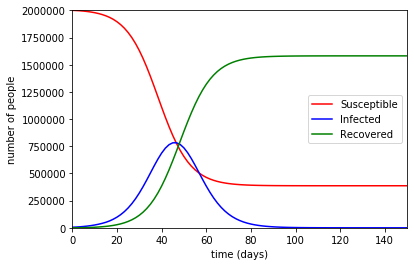

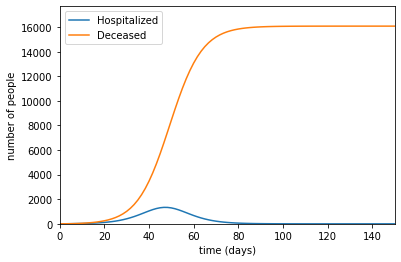

In [36]:
##################################
##                              ##
##      Solve and Output        ##
##                              ##
##################################

if method == 'Predictor_Corrector':
    t, S_t, I_t, Ic_t = solve_Predictor_Corrector(params, IC)
elif method == 'Galerkin':
    t, S_t, I_t, Ic_t =        solve_Galerkin(params, IC, NL, G_method)
elif method == 'Hybrid':
    tc = 0
    count = 0
    IC_t = IC
    while tc < Tf:
        
        #run the next simulation
        if tc < tswap[count]:
            tstep = tswap[count] - tc
            params[3] = tstep
            sol = solve_Galerkin(params, IC_t, NL, G_method,True, tc)
        else:
            tstep = 2
            params[3] = tstep
            sol = solve_Predictor_Corrector(params, IC_t, True, tc)
            if count < len(tswap)-1:
                count += 1
        
        #unpack results
        if count == 0 or (count == 1 and tc == 0):
            t, S_t, I_t, Ic_t, IC_t = sol
        else:
            t  = np.concatenate((t,tc + sol[0]))
            nt = len(t); S_t_new = np.zeros((M,nt)); I_t_new = np.zeros((M,nt)); Ic_t_new = np.zeros((Nc,M,nt))
            for i in range(M):
                S_t_new[i,:] = np.append(S_t[i,:],sol[1][i,:])
            for i in range(M):
                I_t_new[i,:] = np.append(I_t[i,:],sol[2][i,:])
            for i in range(Nc):
                for j in range(M):
                    Ic_t_new[i,j,:] = np.append(Ic_t[i,j,:],sol[3][i,j,:])
            IC_t = sol[4]
            S_t, I_t, Ic_t = [S_t_new, I_t_new, Ic_t_new]
        
        #prepare for next loop
        tc = tc + tstep
        #print(IC_t)

#Plot Results

#Standard SIR plot
plt.figure()    
plt.plot(t*Tc,Np*np.sum(S_t,0),'r', label = 'Susceptible')           #all susceptible
plt.plot(t*Tc,Np*np.sum(I_t,0),'b', label = 'Infected')              #all Infected
plt.plot(t*Tc,Np*np.sum(Ic_t[0,:,:],0),'g', label = subclasses[0])   #all recovered
plt.legend()
plt.xlabel('time (days)');       plt.xlim(0,Tf*Tc)
plt.ylabel('number of people');  plt.ylim(0,Np)

#Other subclasses of Infected:
plt.figure() 
for i in (1 + np.arange(Nc-1)):
    plt.plot(Tc*t,Np*np.sum(Ic_t[i,:,:],0), label = subclasses[i])
plt.legend()
plt.xlabel('time (days)')
plt.ylabel('number of people')
plt.xlabel('time (days)');       plt.xlim(0,Tf*Tc)
plt.ylabel('number of people');  plt.ylim(0,1.1*np.amax(Np*np.sum(Ic_t[2,:,:],0)))

In [41]:
#####################################
##                                 ##
##   Generic cost fn Evaluation    ##
##                                 ##
#####################################

def get_cost(x, gradx, params, IC, cost_params, evaluate_cost, print_figs = False):
    #unpack parameters, sincs some are used.
    M, Nc, Nk, Tf, tsi, beta, tsi_sc, phi_alpha, p_alpha, Cij_t_old = params
    params2 = np.copy(params)
    
    #set up the time-dependent contact matrix based on control scheme
    nu = int((len(x) + 2)/(M + 1))
    t_con = np.append(np.append(0, x[:(nu - 2)]),Tf)
    u_con = np.reshape(x[(nu - 2):],(M,nu))
    def Cij_t_new(t):
        u = np.zeros(M)
        for i in range(M):
            u[i] = np.interp(t,t_con,u_con[i,:])
        return np.outer(u,u)*Cij_t_old(t)

    params2[9] = Cij_t_new
    
    #let's not messs around with poorly sorted lists
    for i in range(nu - 1):
        if t_con[i + 1] < t_con[i]:
            return float('inf')
        
    #integrate forward in time
    t, S_t, I_t, Ic_t = solve_Predictor_Corrector(params2, IC)
    
    #compute cost function
    nt = len(t)
    u_t = np.zeros((M,nt))
    for i in range(nt):
        for j in range(M):
            u_t[j,i] = np.interp(t[i],t_con,u_con[j,:])
            
    #Standard SIR plot
    if print_figs:
        plt.figure()    
        plt.plot(t,np.sum(S_t,0),'r', label = 'Susceptible')           #all susceptible
        plt.plot(t,np.sum(I_t,0),'b', label = 'Infected')              #all Infected
        plt.plot(t,np.sum(Ic_t[0,:,:],0),'g', label = subclasses[0])   #all recovered
        plt.legend()
        plt.xlabel('time (days)');       plt.xlim(0,Tf)
        plt.ylabel('number of people');  plt.ylim(0,1)
    
    return evaluate_cost(t,u_t,S_t,I_t,Ic_t,cost_params)



0.007122656738816574


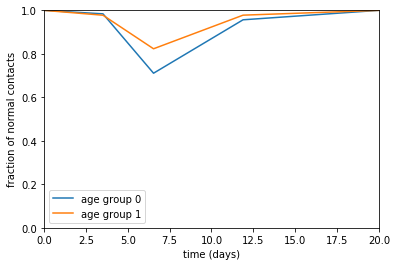

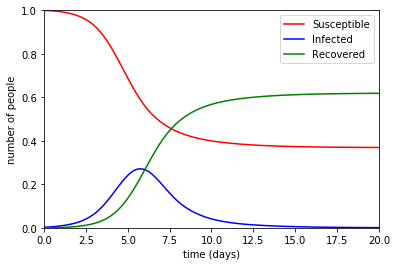

In [44]:
###################################
##                               ##
##       Optimize Controls       ##
##                               ##
###################################

###################################
##     Herd Immunity Example     ##
###################################

#Define the particular cost function

def evaluate_cost(t,u_t,S_t,I_t,Ic_t,cost_params):
    #unpack cost params
    Omega = cost_params
    
    #evaluate costs from infections/death
    nt = len(t)
    pos = 2
    cost_health = np.sum(Ic_t[pos,:,nt-1])
  
    #evaluate costs from implementing controls:
    cost_NPI = Omega*np.trapz(np.sum(((1-u_t)**2)*S_t,0),t)
    return (cost_health + cost_NPI)

#Define input parameters to the cost function:
Omega = 10**-2   #input parameter to trial cost function.  Omega scales cost of lockdown to SvL.
                 #Generalizations should include age-structuring.
    
#bundle all input parameters together
cost_params = Omega


    
nu = 5           #how many interpolating points (including endpoints)

#set an initial guess (evenly spaced points, no intervention)
x0 = np.append(np.linspace(Tf/(nu - 1), Tf*(nu-2)/(nu-1),nu-2), np.ones(nu*M))
nx = len(x0)

#We use nlopt for optimization.
opt = nlopt.opt(nlopt.LN_COBYLA, nx)
opt.set_lower_bounds(np.zeros(nx))
opt.set_upper_bounds(np.append(Tf*np.ones(nu - 2),np.ones(nx - (nu - 2))))
opt.set_min_objective(lambda x, gradx: get_cost(x, gradx, params, IC, cost_params,evaluate_cost))
opt.set_xtol_rel(1e-3)#-4
x_opt = opt.optimize(x0)
minf = opt.last_optimum_value()

#group results and plot
t_con = np.append(np.append(0, x_opt[:(nu - 2)]),Tf)
u_con = np.reshape(x_opt[(nu - 2):],(M,nu))

plt.figure()
for i in range(M):
    lbl = ['age group ', str(i)]
    lbl = ''.join(lbl)
    plt.plot(t_con,u_con[i,:], label = lbl)
plt.legend()
plt.xlabel('time (days)');       plt.xlim(0,Tf)
plt.ylabel('fraction of normal contacts');  plt.ylim(0,1)

print(get_cost(x_opt, [], params, IC, cost_params,evaluate_cost,True))

0.0002929094581893794


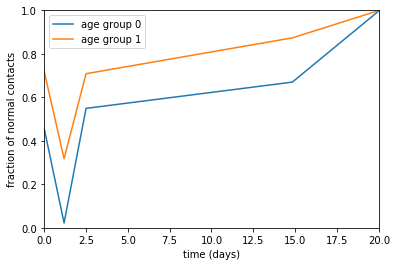

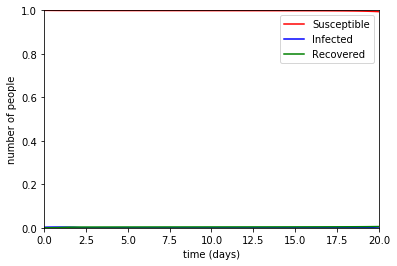

In [45]:
###################################
##                               ##
##       Optimize Controls       ##
##                               ##
###################################

###################################
##     Herd Immunity Example     ##
###################################

#Define the particular cost function

def evaluate_cost(t,u_t,S_t,I_t,Ic_t,cost_params):
    #unpack cost parameters.  In this example we have a one-parameter cost function.
    Omega = cost_params
    
    #evaluate costs from infections/death
    nt = len(t)
    pos = 2
    cost_health = np.sum(Ic_t[pos,:,nt-1])
  
    #evaluate costs from implementing controls:
    cost_NPI = Omega*np.trapz(np.sum(((1-u_t)**2)*S_t,0),t)
    return (cost_health + cost_NPI)

#Define input parameters to the cost function:
Omega = 10**-4   #input parameter to trial cost function.  Omega scales cost of lockdown to SvL.
                 #Generalizations should include age-structuring.
    
#bundle all input parameters together
cost_params = Omega


    
nu = 5           #how many interpolating points (including endpoints)

#set an initial guess (evenly spaced points, no intervention)
x0 = np.append(np.linspace(Tf/(nu - 1), Tf*(nu-2)/(nu-1),nu-2), np.ones(nu*M))
nx = len(x0)

#We use nlopt for optimization.
opt = nlopt.opt(nlopt.LN_COBYLA, nx)
opt.set_lower_bounds(np.zeros(nx))
opt.set_upper_bounds(np.append(Tf*np.ones(nu - 2),np.ones(nx - (nu - 2))))
opt.set_min_objective(lambda x, gradx: get_cost(x, gradx, params, IC, cost_params,evaluate_cost))
opt.set_xtol_rel(1e-3)#-4
x_opt = opt.optimize(x0)
minf = opt.last_optimum_value()

#group results and plot
t_con = np.append(np.append(0, x_opt[:(nu - 2)]),Tf)
u_con = np.reshape(x_opt[(nu - 2):],(M,nu))

plt.figure()
for i in range(M):
    lbl = ['age group ', str(i)]
    lbl = ''.join(lbl)
    plt.plot(t_con,u_con[i,:], label = lbl)
plt.legend()
plt.xlabel('time (days)');       plt.xlim(0,Tf)
plt.ylabel('fraction of normal contacts');  plt.ylim(0,1)

print(get_cost(x_opt, [], params, IC, cost_params,evaluate_cost,True))